# Introduction to DBnomics in Python

This tutorial explains how to obtain economic [time series](https://en.wikipedia.org/wiki/Time_series) from [DBnomics](https://next.nomics.world/), how to manipulate them and how to visualize them.

We will use well-known Python packages to achieve our goal, like [Pandas](http://pandas.pydata.org/) to represent tabular data, and [Altair](https://altair-viz.github.io/) to create the charts.

We will also use the `dbnomics` Python package to obtain data from the DBnomics Web API.

First, let's import those libraries:

In [4]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
from altair import Chart, Scale, Y

from dbnomics import fetch_series, fetch_series_by_api_link

Note: in this notebook we are going to follow the conventions of the Scientific Python community. In particular, the `df` shortcut for `DataFrame`.

# Fetch one time series by its code

First, let's assume that we know which series we want to download. A series identifier (ID) is defined by three values, formatted like this: `provider_code/dataset_code/series_code`. We can use the `fetch_series` function, previously imported from the `dbnomics` Python package.

For example, to fetch the time series `EA19.1.0.0.0.ZUTN` from the ["Unemployment rate" [ZUTN] dataset](https://next.nomics.world/AMECO/ZUTN) belonging to the [AMECO provider](https://next.nomics.world/AMECO):

In [5]:
df1 = fetch_series('AMECO/ZUTN/EA19.1.0.0.0.ZUTN')

The returned data is stored in the `df1` variable. Its type is a [Pandas](http://pandas.pydata.org/) [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe).

Now let's display the first rows of this `DataFrame` by using the `head` method, each row representing an observation of the time series:

In [6]:
df1.head()

,@frequency,Country,Frequency,Unit,dataset_code,dataset_name,freq,geo,period,provider_code,series_code,series_name,unit,value
0,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1960-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
1,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1961-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
2,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1962-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
3,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1963-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
4,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1964-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA


In such `DataFrame`, you will always find at least seven columns:
- provider_code
- dataset_code
- dataset_name
- series_code
- series_name
- period
- value

The other columns depend on the provider and on the dataset. They always come in pairs (for the code and the name). In `df1`, you have:
- `unit` (code) and `Unit` (name) 
- `geo` (code) and `Country` (name)
- `freq` (code) and `Frequency` (name)

To plot the `DataFrame`, we need to remove the missing values (`NA`).

Note: DBnomics defines a unified `NA` value for missing values.

Let's define the following `clean_dataframe` helper function, using Pandas `query` method:

In [7]:
def clean_dataframe(df):
    return df.query("value != 'NA'")

Clean the previously downloaded `df1` `DataFrame`:

In [8]:
df1_clean = clean_dataframe(df1)
df1_clean.head()

,@frequency,Country,Frequency,Unit,dataset_code,dataset_name,freq,geo,period,provider_code,series_code,series_name,unit,value
38,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1998-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,10.4
39,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1999-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,9.7
40,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2000-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,8.9
41,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2001-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,8.3
42,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2002-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,8.6


Here we use the [Altair](https://altair-viz.github.io/) library to render charts, but you can use any other one like matplotlib, bqplot, plotly, etc.

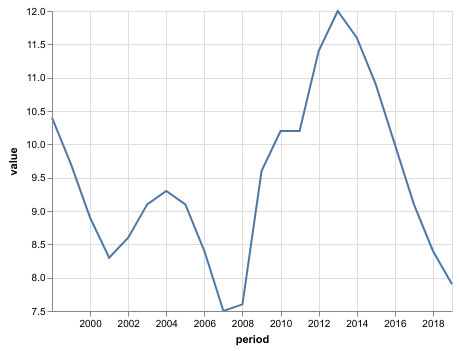

In [9]:
chart = Chart(df1_clean).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
)
chart

# Fetch two time series by their codes

Again, let's assume that we know which series we want to download. We can reuse the `fetch_series` function, this time with two series codes.

For example, to fetch the time series `EA19.1.0.0.0.ZUTN` and `DNK.1.0.0.0.ZUTN` from the ["Unemployment rate" [ZUTN] dataset](https://next.nomics.world/AMECO/ZUTN) belonging to the [AMECO provider](https://next.nomics.world/AMECO):

In [10]:
df2 = fetch_series([
    'AMECO/ZUTN/EA19.1.0.0.0.ZUTN',
    'AMECO/ZUTN/DNK.1.0.0.0.ZUTN',
])
df2.head()

,@frequency,Country,Frequency,Unit,dataset_code,dataset_name,freq,geo,period,provider_code,series_code,series_name,unit,value
0,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1960-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
1,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1961-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
2,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1962-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
3,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1963-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
4,annual,Euro area,Annually,(Percentage of active population),ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,1964-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA


In [11]:
df2_clean = clean_dataframe(df2).query("period >= '2000'")

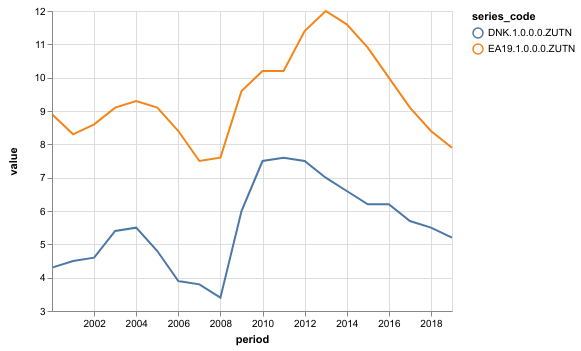

In [12]:
chart = Chart(df2_clean).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart

## Fetch time series by their dimensions

When you don't know the codes of the series, you can give a `dict` of dimensions to the `fetch_series` function, and it will return a `DataFrame` containing all the matching series. Here you must know the provider code, the dataset code, and the codes of the dimensions.

For example, to fetch:
- many series
- from the ["Doing Business" [DB]](https://next.nomics.world/WB/DB) dataset of the [World Bank](https://next.nomics.world/WB) provider
- searching for time series about France, Italy and Spain (`country` dimension)
- and searching for the indicator "Procedures required to start a business - Women (number)" (`indicator` dimension):

In [13]:
df3 = fetch_series("WB", "DB", dimensions={
    "country": ["FR", "IT", "ES"],
    "indicator": ["IC.REG.PROC.WOMEN"],
})
df3.head()

,@frequency,ATTRIBUTE,country,country_label,dataset_code,dataset_name,indicator,indicator_label,period,provider_code,series_code,series_name,value
0,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2003-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0
1,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2004-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0
2,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2005-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0
3,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2006-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0
4,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2007-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0


To know the codes of the time series you got:

In [14]:
df3.series_code.unique().tolist()

['IC.REG.PROC.WOMEN-ES', 'IC.REG.PROC.WOMEN-FR', 'IC.REG.PROC.WOMEN-IT']

In [15]:
df3_clean = clean_dataframe(df3)

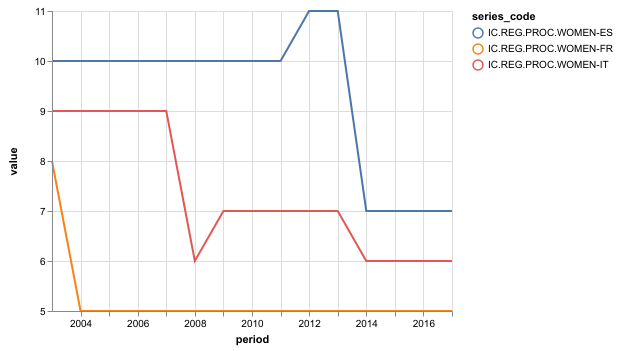

In [16]:
chart = Chart(df3_clean).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart

## Fetch time series found on the web site

When you don't know the codes of the dimensions, provider, dataset or series, you can:

- go to the page of a dataset on DBnomics website, for example [Doing Business](https://next.nomics.world/WB/DB),
- select some dimensions by using the input widgets of the left column,
- click on "Copy API link" in the menu of the "Download" button,
- use the `fetch_series_by_api_link` function such as below.

In [17]:
df4 = fetch_series_by_api_link("https://api.next.nomics.world/series?dimensions=%7B%22country%22%3A%5B%22FR%22%2C%22IT%22%2C%22ES%22%5D%2C%22indicator%22%3A%5B%22IC.REG.PROC.WOMEN%22%5D%7D&provider_code=WB&dataset_code=DB")
df4.head()

,@frequency,ATTRIBUTE,country,country_label,dataset_code,dataset_name,indicator,indicator_label,period,provider_code,series_code,series_name,value
0,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2003-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0
1,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2004-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0
2,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2005-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0
3,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2006-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0
4,annual,,ES,Spain,DB,Doing Business,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2007-01-01,WB,IC.REG.PROC.WOMEN-ES,Procedures required to start a business - Wome...,10.0


In [18]:
df4_clean = clean_dataframe(df4)

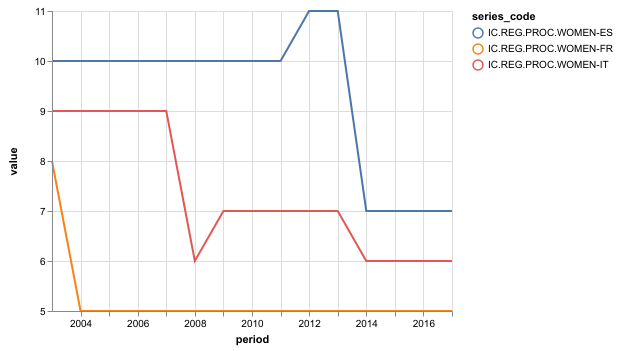

In [19]:
chart = Chart(df4_clean).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart

The chart is exactly the same than the previous one.

## Fetch time series from the cart

On the [cart page](https://next.nomics.world/cart) of the DBnomics website, click on "Copy API link" and copy-paste it as an argument of the `fetch_series_by_api_link` function.

Please note that when you update your cart, you have to copy this link again, because the link itself contains the IDs of the series in the cart.

In [20]:
cart_df = fetch_series_by_api_link("https://api.next.nomics.world/series?series_ids=BOE%2F8745%2FLPMB23A%2CBOE%2F8745%2FLPMB26A")
cart_df.head()

,@frequency,dataset_code,dataset_name,period,provider_code,series_code,series_name,value
0,monthly,8745,Monthly lending secured on dwellings: approvals,1999-01-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,940.0
1,monthly,8745,Monthly lending secured on dwellings: approvals,1999-02-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,1569.0
2,monthly,8745,Monthly lending secured on dwellings: approvals,1999-03-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,2099.0
3,monthly,8745,Monthly lending secured on dwellings: approvals,1999-04-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,1851.0
4,monthly,8745,Monthly lending secured on dwellings: approvals,1999-05-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,1871.0


## Fetch series using a code mask

In [21]:
code_mask_df = fetch_series("IMF", "CPI", code_mask="M.FR+DE.PCPIEC_IX+PCPIA_IX")
code_mask_df = clean_dataframe(code_mask_df).query("period >= '2000' and period < '2002'")
code_mask_df.head()

,@frequency,FREQ,Frequency,INDICATOR,Indicator,REFERENCE_PERIOD,REF_AREA,Reference Area,dataset_code,dataset_name,period,provider_code,series_code,series_name,value
108,monthly,M,Monthly,PCPIA_IX,Clothing and footwear,2010A,DE,Germany,CPI,Consumer Price Index (CPI),2000-01-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.4
109,monthly,M,Monthly,PCPIA_IX,Clothing and footwear,2010A,DE,Germany,CPI,Consumer Price Index (CPI),2000-02-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.2
110,monthly,M,Monthly,PCPIA_IX,Clothing and footwear,2010A,DE,Germany,CPI,Consumer Price Index (CPI),2000-03-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.4
111,monthly,M,Monthly,PCPIA_IX,Clothing and footwear,2010A,DE,Germany,CPI,Consumer Price Index (CPI),2000-04-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.5
112,monthly,M,Monthly,PCPIA_IX,Clothing and footwear,2010A,DE,Germany,CPI,Consumer Price Index (CPI),2000-05-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.4


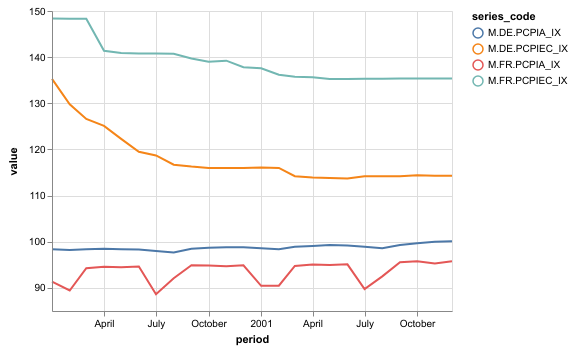

In [22]:
chart = Chart(code_mask_df).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart

## Mixing different frequencies on the same chart

In [23]:
multi_freq_df = clean_dataframe(fetch_series([
    "BEA/NIUnderlyingDetail-U001BC/S315-A",
    "BEA/NIUnderlyingDetail-U001BC/S315-Q",
    "BEA/NIUnderlyingDetail-U001BC/S315-M",
]))

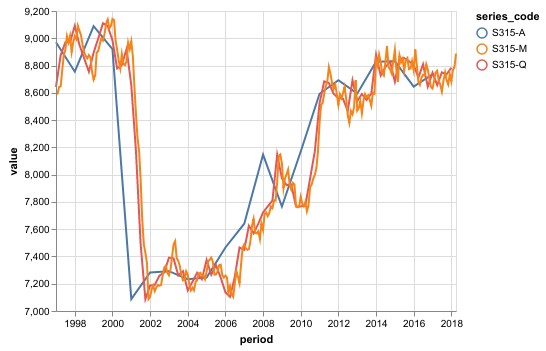

In [24]:
chart = Chart(multi_freq_df).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart